### Описание проекта

Оператор связи «ТелеДом» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. 

#### Описание услуг

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию DSL (от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

#### Описание данных
Данные хранятся в таблицах в базе данных PostgreSQL:

- contract — информация о договоре,
- personal — персональные данные клиента,
- internet — информация об интернет-услугах,
- phone — информация об услугах телефонии.

Таблица `telecom.contract`
- customerID — ID пользователя,
- BeginDate — дата начала действия,
- EndDate — дата окончания действия,
- Type — тип оплаты (раз в год или помесячно),
- PaperlessBilling — безбумажный расчётный лист,
- PaymentMethod — тип платежа,
- MonthlyCharges — расход за месяц,
- TotalCharges — общие расходы.

Таблица `personal`
- customerID — ID пользователя,
- gender — пол,
- SeniorCitizen — является ли абонент пенсионером,
- Partner — есть ли у абонента супруг/супруга,
- Dependents — есть ли у абонента дети.

Таблица `telecom.internet`
- customerID — ID пользователя,
- InternetService — тип подключения,
- OnlineSecurity — блокировка небезопасных сайтов,
- OnlineBackup — облачное хранилище файлов для резервного копирования данных,
- DeviceProtection — антивирус,
- TechSupport — выделенная линия технической поддержки,
- StreamingTV — стриминговое телевидение,
- StreamingMovies — каталог фильмов.

Таблица `telecom.phone`
- customerID — ID пользователя,
- MultipleLines — подключение телефонного аппарата к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

In [26]:
# заранее укажем с какими библиотеками будем работать
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns

!pip install phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

from catboost import CatBoostClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

### Подключение к базе данных

Подключимся к базе данных, откуда будем выгружать таблицы с нужной информацией.

In [27]:
# параметры для соединения к БД
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-final' # название базы данных,
} 

In [28]:
# подключение к БД
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

engine = create_engine(connection_string)

### Исследовательский анализ данных

Проанализируем исходные данные на входе. А именно:
- Все ли таблицы имеют набор данных.
- Соответствует ли количество таблиц условию задачи.
- Имеется ли общий ключ для связи таблиц.
- Сравним распределения величин ежемесячных платежей (MonthlyCharges) всех действующих клиентов и тех, кто ушёл. Для каждой группы посчитаем статистические показатели: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Построим гистограммы распределения.
- Сравним поведение клиентов этих двух групп. Для каждой построим два графика, отражающие:
    - долю пользователей телефонной связи,
    - долю интернет-пользователей.
    
- Выделим целевую переменную на основе поля EndDate.

In [29]:
# выведем на экран первые 5 строки каждой таблицы
tables = ['telecom.contract', 'telecom.personal', 'telecom.internet', 'telecom.phone']
for table in tables:
    query = f'''
                SELECT *
                FROM {table}
                LIMIT 5;
             '''
    print('Таблица:', table)
    display(pd.read_sql_query(query, con=engine))

Таблица: telecom.contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


Таблица: telecom.personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Таблица: telecom.internet


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


Таблица: telecom.phone


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


Как оказалось, у таблиц telecom.internet и telecom.phone наименование столбцов смещены вниз.
Отметим, что каждая таблица связана между собой по столбцу 'customerID'.

In [30]:
# сохраним каждую таблицу в отдельную переменную
query = f'''
            SELECT *
            FROM telecom.contract
            ;
         '''
df_contract = pd.read_sql_query(query, con=engine)

query = f'''
            SELECT *
            FROM telecom.personal
            ;
         '''
df_personal = pd.read_sql_query(query, con=engine)

query = f'''
            SELECT *
            FROM telecom.internet
            ;
         '''
df_internet = pd.read_sql_query(query, con=engine)
df_internet.columns = df_internet.iloc[0]
df_internet = df_internet.drop(index=0).reset_index(drop=True) #index=df.index[0]

query = f'''
            SELECT *
            FROM telecom.phone
            ;
         '''
df_phone = pd.read_sql_query(query, con=engine)
df_phone.columns = df_phone.iloc[0]
df_phone = df_phone.drop(index=0).reset_index(drop=True) #index=df.index[0]

In [31]:
# выведем на экран общую информацию таблицы telecom.contract
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Столбцы 'BeginDate' и 'EndDate' лучше будет перевести в формат datetime. Среди данных есть пустые ячейки. Покажем их отдельно.

In [32]:
# строки, в которых 'TotalCharges' имеет значение Null
df_contract[df_contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN


Все они приходятся на '2020-02-01'.

Более детально изучим столбцы 'TotalCharges' и 'MonthlyCharges'.

In [33]:
# рассмотрим случаи, когда "MonthlyCharges" < "TotalCharges"
df_contract[df_contract['MonthlyCharges'] < df_contract['TotalCharges']].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
12,0280-XJGEX,2018-11-13,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30


Как мы видим, в нашей таблице имеются аномалии. Например, за 10 месяцев у клиента `9237-HQITU` общий расход составил 151.65, в то время как месячная подписка стоила 70.70.	

Если в колонку 'MonthlyCharges' записывается постоянный ежемесячный платеж, то 'TotalCharges' будет равен как минимум произведению 'MonthlyCharges' на количество месяцев.

В таком случае, мы должны либо отредактировать столбец 'TotalCharges' либо избавиться от него.

Стоит выяснить, как вносятся данные в таблицу и за что отвечают столбцы 'TotalCharges' и 'MonthlyCharges'. 

Если случился баг при записи данных, можно попробовать умножить аномалии на 10. Тогда мы получим близкие по смыслу значения. Но требуется этот момент уточнить.

Пока что оставим этот столбец и не будем использовать в качестве признака в моделировании.

In [34]:
# оценим, сколько действующих клиентов и тех, кто ушёл
cleint_active_perc = len(df_contract[df_contract['EndDate'].isna()]) / len(df_contract)
cleint_passive_perc = len(df_contract[~df_contract['EndDate'].isna()]) / len(df_contract)
print(f'Доля активных клиентов составляет {round(cleint_active_perc, 2)}, а пассивных - {round(cleint_passive_perc, 2)}.')

Доля активных клиентов составляет 0.73, а пассивных - 0.27.


In [35]:
# 'MonthlyCharges' у активных клиентов
df_contract[df_contract['EndDate'].isna()]['MonthlyCharges'].describe()

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

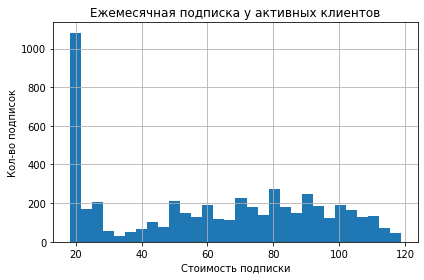

In [36]:
plt.figure(figsize=(6, 4))
df_contract[df_contract['EndDate'].isna()]['MonthlyCharges'].hist(bins=30)
plt.xlabel('Стоимость подписки')
plt.ylabel('Кол-во подписок')
plt.title('Ежемесячная подписка у активных клиентов')
plt.tight_layout()
None

In [37]:
# 'MonthlyCharges' у пассивных клиентов
df_contract[~df_contract['EndDate'].isna()]['MonthlyCharges'].describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

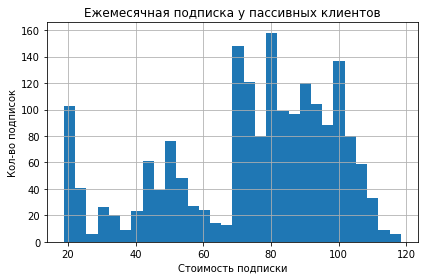

In [38]:
plt.figure(figsize=(6, 4))
df_contract[~df_contract['EndDate'].isna()]['MonthlyCharges'].hist(bins=30)
plt.xlabel('Стоимость подписки')
plt.ylabel('Кол-во подписок')
plt.title('Ежемесячная подписка у пассивных клиентов')
plt.tight_layout()
None

Из вышепоказанного видно, что средняя подписка пассивных клиентов выше, чем у активных. Можно предположить, что причиной отказа служит высокие цены на тариф. 
Если мы сократим отток клиентов, то нам удастся сохранить потребительский спрос и увеличить прибыль.

In [39]:
# оценим, сколько пользователей пользуются тарифами телефонной связи и интернетом
df_merge = (df_contract[['customerID', 'BeginDate', 'EndDate']]
            .merge(df_internet[['customerID', 'InternetService']], on='customerID')
            .merge(df_phone, on='customerID')
           )
df_merge.head()

,customerID,BeginDate,EndDate,InternetService,MultipleLines
0,3668-QPYBK,2018-08-09,2019-12-01,DSL,No
1,5709-LVOEQ,2020-02-01,None,DSL,No
2,9237-HQITU,2019-01-26,2019-11-01,Fiber optic,No
3,9305-CDSKC,2018-12-26,2019-11-01,Fiber optic,Yes
4,7892-POOKP,2019-04-27,2019-11-01,Fiber optic,Yes


In [40]:
df_merge[df_merge['EndDate'].isna()]['MultipleLines'].value_counts()

Yes    1789
No     1460
Name: MultipleLines, dtype: int64

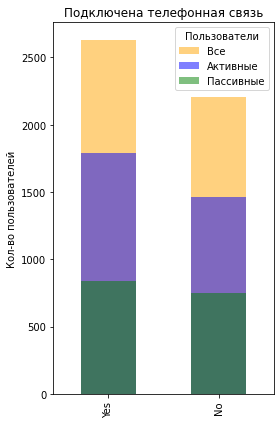

In [41]:
# телефония
plt.figure(figsize=(4, 6))
plt.title('Подключена телефонная связь')
#plt.xlabel('')
plt.ylabel('Кол-во пользователей')
df_merge['MultipleLines'].value_counts().plot(kind='bar', color='orange', alpha=0.5)
df_merge[df_merge['EndDate'].isna()]['MultipleLines'].value_counts().plot(kind='bar', color='blue', alpha=0.5)
df_merge[~df_merge['EndDate'].isna()]['MultipleLines'].value_counts().plot(kind='bar', color='green', alpha=0.5)
plt.legend(['Все', 'Активные', 'Пассивные'],
           title='Пользователи')
plt.tight_layout()
None


Телефония распределено равномерно. Поведение клиентов схожи. В обеих группах пропорциональное количество клиентов, у которых имеется доступ к данной услуге.

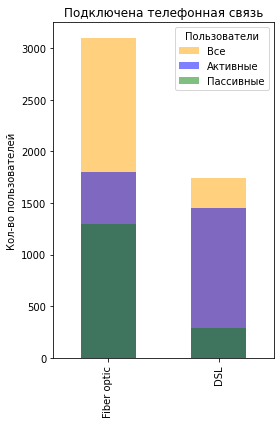

In [42]:
# интернет
plt.figure(figsize=(4, 6))
plt.title('Подключена телефонная связь')
#plt.xlabel('')
plt.ylabel('Кол-во пользователей')
df_merge['InternetService'].value_counts().plot(kind='bar', color='orange', alpha=0.5)
df_merge[df_merge['EndDate'].isna()]['InternetService'].value_counts().plot(kind='bar', color='blue', alpha=0.5)
df_merge[~df_merge['EndDate'].isna()]['InternetService'].value_counts().plot(kind='bar', color='green', alpha=0.5)
plt.legend(['Все', 'Активные', 'Пассивные'],
           title='Пользователи')
plt.tight_layout()

None

Здесь наблюдается резкий дисбаланс между групами клиентов. Активные клиенты почти поровну используют оба типа подключения, а у пассивных преобладет Fiber optic.

Это может быть связано с техническими характерстиками. Можно найти статью, где указано, что Fiber optic не позволяет работать с услугами по телефонии. Стоит распросить об этом у заказчика. В случае подтвержения, существует вероятность, что данная причина может служить оттоку клиентов.

Подытожим анализ:
- В нашем распоряжении 4 таблиц, связанных между собой по столбцу 'customerID'.
- Ключевая таблица 'telecom.contract' имеет 7 тыс. записей (скорее всего, качество прогнозов будет невысокой).
- Были обнаружены несоответстсвия в данных, которые потребуется устранить.
- Более детально показали ежемесячный расход пользователей, предварительно поделив их на две группы - активные и пассивные (те, кто отказались от подписки).
- Отобразили распределение по тарифам для каждой группы клиентов, и выявили их особенности.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Верно!👍:\
</b> Мне интересно было изучить твои графики, осмысленный и красочный графический анализ. Найдены очень интересные закономерности, а выводы логичны)

### Подготовка данных

Выполним следующее:
- Приведем данные к необходимому виду (обновим столбцы, и их типы).
- Преобразуем целевой признак. 
- Создадим датасет, в котором оставим столбцы для будущей модели, и разобьем его на три составляющие: тренировочную, валидационную и тестовую часть.
- С помощью One Hot Encoding категориальные признаки приведем к численным.
- Масштабируем данные, в котором содержатся большие значения.


In [43]:
# создадим отдельный столбец для целевого признака
df_contract['active'] = df_contract['EndDate'].isna().astype(int)

In [44]:
# заменим Null на последнюю актуальную дату 
df_contract.loc[df_contract['EndDate'].isna(), 'EndDate'] = '2020-02-01'

In [45]:
# приведем даты к нужному формату
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d')

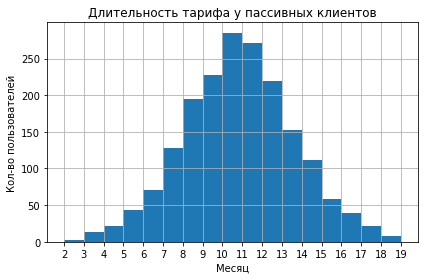

In [46]:
# визуально покажем, сколько по времени было в пользовании у пассивных клиентов
df_contract['month_delta'] = df_contract['EndDate'].dt.to_period('M').astype(int) - \
                             df_contract['BeginDate'].dt.to_period('M').astype(int)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(range(0, 20, 1))
plt.title('Длительность тарифа у пассивных клиентов')
plt.xlabel('Месяц')
plt.ylabel('Кол-во пользователей')
df_contract[df_contract['active'] == 0]['month_delta'].hist(bins=17)
plt.tight_layout()
None

Чаще всего, клиенты до того, как отменить подписку, пользуются услугами более шести месяцев. Мы теряем больше постоянных подписчиков, чем новых.

In [47]:
# объединим все признаки
df_merge = (df_contract.merge(df_personal, on='customerID')
            .merge(df_internet, on='customerID', how='left')
            .merge(df_phone, on='customerID', how='left')
            )

In [48]:
# инфа по таблице
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   active            7043 non-null   int64         
 9   month_delta       7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

In [49]:
# заполним пустоты
df_merge['TotalCharges'] = df_merge['TotalCharges'].fillna(0)
#df_merge['InternetService'] = df_merge['InternetService'].fillna('unknown')
df_merge = df_merge.fillna('No')

In [50]:
# удалим те столбцы, которые будут плохо отражаться на качестве модели
df_merge = df_merge.drop(columns=['customerID', 'BeginDate', 'EndDate', 'TotalCharges'])

interval columns not set, guessing: ['MonthlyCharges', 'active', 'month_delta', 'SeniorCitizen']


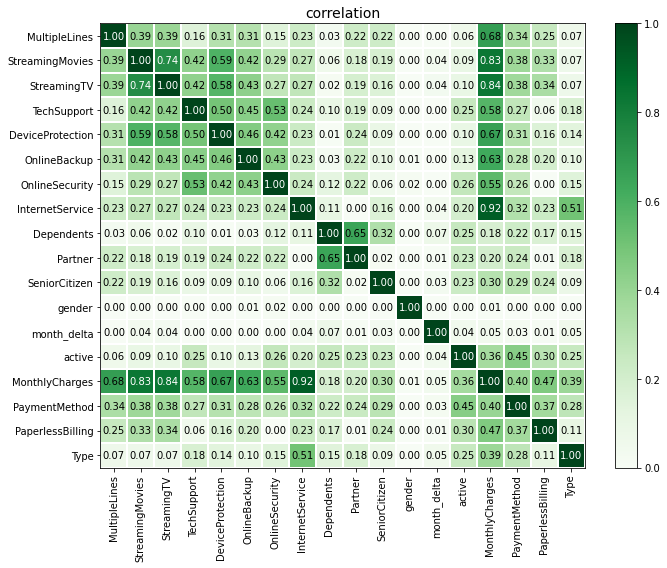

In [51]:
# построим матрицу корреляции
phik_overview = df_merge.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation", 
                        fontsize_factor=1, 
                        figsize=(10, 8))
plt.tight_layout()

Наблюдается мультиколлиарность по нескольким признакам. В нашей работе мы не будем использовать линейную регрессию, поэтому это можно опустить.

In [52]:
# разделим датасеты на тренировочную, валидационную и тестовую часть
target = 'active'

features_train, features_test, target_train, target_test = train_test_split(df_merge.drop(columns=target),
                                                                            df_merge[target],
                                                                            shuffle=True,
                                                                            random_state=23,
                                                                            stratify=df_merge[target],
                                                                            test_size=0.25)

#features_train, features_temp, target_train, target_temp = train_test_split(df_merge.drop(columns=target),
                                                                            #df_merge[target],
                                                                            #shuffle=True,
                                                                            #random_state=23,
                                                                            #stratify=df_merge[target],
                                                                            #test_size=0.3)

#features_valid, features_test, target_valid, target_test = train_test_split(features_temp,
                                                                            #target_temp,
                                                                            #shuffle=True,
                                                                            #random_state=23,
                                                                            #stratify=target_temp,
                                                                            #test_size=0.5)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Целевой признак добавлен корректно

In [53]:
# покажем размеры датасетов
print(f'Train shape is {features_train.shape}.')
#print(f'Valid shape is {features_valid.shape}.')
print(f'Test shape is {features_test.shape}.')

Train shape is (5282, 17).
Test shape is (1761, 17).


In [54]:
# отделим столбцы, у которых указан тип 'object'
cat_cols = []
for col in features_train.columns:
    if features_train[col].dtype == 'object':
        cat_cols.append(col)

features_train_oe = features_train[cat_cols]
#features_valid_oe = features_valid[cat_cols]    
features_test_oe = features_test[cat_cols]        

In [55]:
# One Hot Encoding
encoder = OneHotEncoder(drop='first', sparse=False) #, handle_unknown='ignore')
encoder.fit(features_train_oe)

#encoder.get_feature_names() имена столбцов

features_train_oe = pd.DataFrame(encoder.transform(features_train_oe), 
                                 columns=encoder.get_feature_names(), 
                                 index=features_train_oe.index
                                 )
#features_valid_oe = pd.DataFrame(encoder.transform(features_valid_oe), 
                                 #columns=encoder.get_feature_names(), 
                                 #index=features_valid_oe.index
                                 #)
features_test_oe = pd.DataFrame(encoder.transform(features_test_oe), 
                                columns=encoder.get_feature_names(), 
                                index=features_test_oe.index
                                )

features_train = pd.concat([features_train.drop(columns=cat_cols), features_train_oe], axis=1)
#features_valid = pd.concat([features_valid.drop(columns=cat_cols), features_valid_oe], axis=1)
features_test = pd.concat([features_test.drop(columns=cat_cols), features_test_oe], axis=1)

In [56]:
# масштабирование
num_cols = ['MonthlyCharges'] #, 'TotalCharges']
scaler = StandardScaler()
scaler.fit(features_train[num_cols])

features_train[num_cols] = scaler.transform(features_train[num_cols])                            
#features_valid[num_cols] = scaler.transform(features_valid[num_cols])
features_test[num_cols] = scaler.transform(features_test[num_cols])

In [57]:
features_train.head(3)

,MonthlyCharges,month_delta,SeniorCitizen,x0_One year,x0_Two year,x1_Yes,x2_Credit card (automatic),x2_Electronic check,x2_Mailed check,x3_Male,...,x5_Yes,x6_Fiber optic,x6_No,x7_Yes,x8_Yes,x9_Yes,x10_Yes,x11_Yes,x12_Yes,x13_Yes
4581,-0.337762,9,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5813,-0.633289,10,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
5939,-0.289343,11,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


Таким образом, мы привели данные к рабочему виду. Теперь их можно использовать в обучении и тестировании модели.

### Обучение модели
Обучим несколько моделей, сравним время обучения и их качество. Выберем среди них самую оптимальную. Расссмотрим решающее дерево, бустинг и нейронную сеть. 

В качестве оценки рекомендуется взять AUC-ROC. Его можно использовать в случае, когда требуется показать в равной мере метрики True Positive и True Negative.

P.S. 

Я не уверен вот в чем. В формуах говорится, что AUC-ROC плохо справляется с дисбалансом (поэтому лучше использовать f1-меру). Но я сильно запустался в этом. Можно, пожалуйста, подсказать, когда лучше всего использовать AUC-ROC, а когда f1-меру. И немного разъяснить в чем их особенности.

In [58]:
# DecisionTreeClassifier
model_dt = DecisionTreeClassifier(random_state=23)
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': range(4, 8)}
grid = GridSearchCV(model_dt, param_grid=param_grid, cv=5, scoring='roc_auc')
grid.fit(features_train, target_train)

print(f'ROC-AUC valid: {round(grid.best_score_, 4)}',
      f'Наилучшие параметры:',
      f'Criterion - {grid.best_params_["criterion"]}',
      f'Max_depth - {grid.best_params_["max_depth"]}',
      sep='\n')

ROC-AUC valid: 0.8044
Наилучшие параметры:
Criterion - entropy
Max_depth - 5


In [59]:
# подготовка данных для CatboostClassifier
num_cols = ['MonthlyCharges', 'month_delta', 'SeniorCitizen']

df_cb = df_merge.copy()
df_cb[cat_cols] = df_cb[cat_cols].astype('category')
df_cb[num_cols] = df_cb[num_cols].astype('int8')

x_train_cb, x_test_cb, y_train_cb, y_test_cb = train_test_split(df_cb.drop(columns=target),
                                                                df_cb[target],
                                                                test_size=0.25,
                                                                random_state=23
                                                               )

x_train_cb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1936 to 595
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              5282 non-null   category
 1   PaperlessBilling  5282 non-null   category
 2   PaymentMethod     5282 non-null   category
 3   MonthlyCharges    5282 non-null   int8    
 4   month_delta       5282 non-null   int8    
 5   gender            5282 non-null   category
 6   SeniorCitizen     5282 non-null   int8    
 7   Partner           5282 non-null   category
 8   Dependents        5282 non-null   category
 9   InternetService   5282 non-null   category
 10  OnlineSecurity    5282 non-null   category
 11  OnlineBackup      5282 non-null   category
 12  DeviceProtection  5282 non-null   category
 13  TechSupport       5282 non-null   category
 14  StreamingTV       5282 non-null   category
 15  StreamingMovies   5282 non-null   category
 16  MultipleLines     5282

In [60]:
# CatboostClassifier
model_cb = CatBoostClassifier(loss_function='Logloss',
                              eval_metric='AUC',
                              cat_features=cat_cols,
                              random_state=23,
                              verbose=False,
                              custom_metric='AUC:hints=skip_train~false',
                              metric_period=20
                             )
param_grid = {'depth': range(4, 8),
              'iterations': [160, 180, 200, 220]
             }
model_cb.grid_search(param_grid=param_grid,
                     X=x_train_cb,
                     y=y_train_cb,
                     cv=5,
                    )

print(f'ROC-AUC valid: {round(model_cb.get_best_score()["learn"]["AUC"], 4)}',
      'Наилучшие параметры:',
      f'Depth: {model_cb.get_params()["depth"]}',
      f'Iterations: {model_cb.get_params()["iterations"]}',
      sep='\n')



bestTest = 0.8233320798
bestIteration = 159

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8233321	best: 0.8233321 (0)	total: 1.13s	remaining: 16.9s

bestTest = 0.8238090215
bestIteration = 179

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8238090	best: 0.8238090 (1)	total: 1.62s	remaining: 11.3s

bestTest = 0.8221626555
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8221627	best: 0.8238090 (1)	total: 2.29s	remaining: 9.9s

bestTest = 0.8226556481
bestIteration = 219

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8226556	best: 0.8238090 (1)	total: 3.02s	remaining: 9.05s

best

In [61]:
# Neural network
def model_creator(optimizer):
    rate = .1

    model_nn = Sequential() # создаем модель

    model_nn.add(Dense(units=64, input_dim=features_train.shape[1], activation='relu')) # добавляем слои
    model_nn.add(Dropout(rate=rate))
    model_nn.add(Dense(units=32, activation='relu'))
    model_nn.add(Dropout(rate=rate))
    model_nn.add(Dense(units=1, activation='sigmoid'))
    model_nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) # указаываем параметры нейронной сети

    return model_nn

classifier = KerasClassifier(build_fn=model_creator) #, verbose=0)

param_grid = {'optimizer': ['adam', 'rmsprop'],
              'batch_size': [16, 32,],
              'epochs': [50, 100,],
              }

grid = GridSearchCV(classifier, param_grid=param_grid, cv = 5, scoring='roc_auc')
grid.fit(features_train, target_train, verbose = 0)

print(f'ROC-AUC valid: {round(grid.best_score_, 4)}',
      f'Наилучшие параметры:',
      f'Optimizer - {grid.best_params_["optimizer"]}',
      f'Batch_size - {grid.best_params_["batch_size"]}',
      f'Epochs - {grid.best_params_["epochs"]}',
      sep='\n')

/tmp/ipykernel_31/2934059006.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier = KerasClassifier(build_fn=model_creator) #, verbose=0)
2023-02-02 17:10:45.866904: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ROC-AUC valid: 0.8147
Наилучшие параметры:
Optimizer - rmsprop
Batch_size - 16
Epochs - 50


Лучшие показатели у CatboostClassifier - время обучения значительно меньше, чем у нейронной сети, а ROC-AUC равен 0.85.

### Тестирование модели

Используем CatboostClassifier, чтобы выяснить, к какому типу относится наш клиент. В случае, если модель предскажет, что клиент собирается отменить подписку (не активный), ему будут оказаны допуслуги.

In [72]:
# ROC_AUC
print('CatboostClassifier')
print(f'ROC-AUC test: {round(roc_auc_score(y_test_cb, model_cb.predict_proba(x_test_cb)[:, 1]), 4)}')

CatboostClassifier
ROC-AUC test: 0.8222


Valid ROC-AUC равен 0.85, а test - 0.82. 

P.S.

Может быть данные неудачно расфосафались? Не могу точно ответить, что повлияло на это.

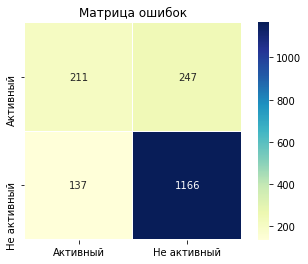

In [63]:
# покажем матрицу ошибок модели CatBoostClassifier
sns.heatmap(confusion_matrix(y_test_cb, model_cb.predict(x_test_cb)),
            cmap='YlGnBu',
            square=True, 
            linewidths=0.1,
            annot=True,
            fmt='d', 
            xticklabels=['Активный', 'Не активный'], 
            yticklabels=['Активный', 'Не активный']
           ).set_title('Матрица ошибок')
None

Модель верно предсказала 221 (63%) объектов положительного класса и 1166 (82%) отрицательного.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Матрица ошибок выведена. Довольно полезный инструмент для анализа модели.

Выявим, какие признаки больше всего влияют на клиентов по версии CatBoostClassifier:

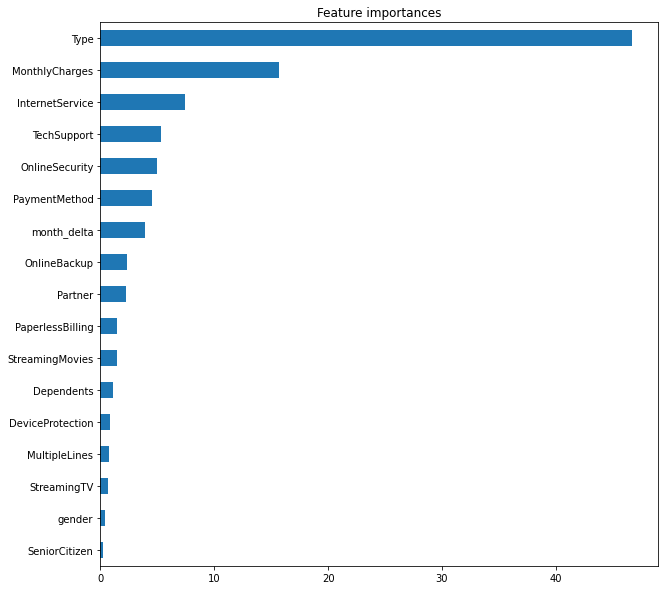

In [64]:
plt.title('Feature importances')
(abs(pd.Series(model_cb.feature_importances_,
               index=model_cb.feature_names_)
    )
 .sort_values()
 .plot(kind='barh',
       figsize=(10,10)
      )
)
None

На первом месте, тип оплаты (раз в год или помесячно). Далее идут расходы за месяц, тип оплаты и пользование тарифом по времени.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Молодец, что не забываешь оценить важность признаков модели

Покажем, как распределены тип оплаты и target.

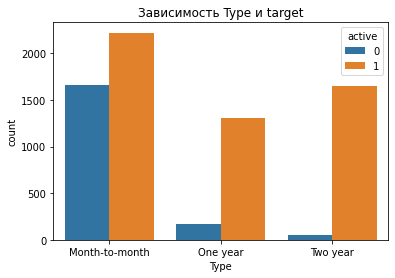

In [65]:
type_gr = df_merge.groupby(target)['Type'] \
                  .value_counts() \
                  .rename('count') \
                  .reset_index()
sns.barplot(data = type_gr, y = 'count', x = 'Type', hue = target)
plt.title('Зависимость Type и target')
None

По графику можно предположить, что больше всего оттока у клиентов с ежедневной подпиской. Но у нас датасет небольшой. Необходимо увеличить диапозон выгрузки. Или вовсе икслючить его. 

P.S. Верно ли я размышляю? Я не стал удалять признак Type при обучении модели (или все таки стоило?)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Да, лучше увеличить диапозон выгрузки. С трейном мы можем делать все, что хотим, главное без утечки

### Заключение

В ходе работы мы:
- Построили алгоритм действий, по которому можно обновлять и добовлять новые условия;
- Исследовали данные, и привели их к нужному виду;
- Определили модель, которая лучше всего справляется с поставленной задачей;
- Оценили нашу модель, и более подробно показали ее характеристики;

Чтобы улучшить модели, предлагаю увеличить наш датасет. Можно актуализировать данные. Последняя запись была 01.02.2020. 